# Hiragana Differentiator

In [2]:
import os
import re
import struct
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from keras import optimizers, callbacks, models, layers
import matplotlib.pyplot as plt

---
## Part I - Preparing the Data

In [4]:
vowels = ['A','I','U','E','O']
consonants = ['','K','S','T','N','H','M','Y','R','W']
goju = [c+v for v in vowels for c in consonants]

goju.append('N') # the 'NN' (batsu-on) that does not have a vowel attached
[goju.remove(x) for x in ['YE','YI','WI','WU','WE']]  # there are no such hiraganas

print(f"There are {len(goju)} hiragana characters (without voiced consonants) in the Japanese alphabet, despite it being called gojuon, the fifty sounds.")

There are 46 hiragana characters (without voiced consonants) in the Japanese alphabet, despite it being called gojyu-on, the fifty sounds.


### Getting metadata from the ETL7INFO file
Generates a dictionary containing (<ins>*file name*</ins> : <ins>*number of samples in the file*</ins>) pairs

See [this page](http://etlcdb.db.aist.go.jp/etlcdb/etln/etl7/etl7.htm) for information of the source (it is in Japanese, though).  

* The page counts 16800 samples, where in fact each corresponds to characters written in two boxes (文字枠), one in a small box and another in a large box; hence there are 16800\*2=33600 images.  

* LC contains the samples from large boxes, and SC from small ones.  
* The metadata contains information about files that are absent from the downloaded package.

In [5]:
file_dir = r'ETL7'

metadata = {}

with open(os.path.join(file_dir,'ETL7INFO')) as info:
    for line in info:
        
        line = repr(line).replace('\\t',' ').replace('\\n','')

        filename = line.split(' ')[0].upper().replace("'",'')

        n_recs_regex = re.compile('\=([0-9]*)record')  # use regex to extract the number of samples in each file
        n_recs = int(n_recs_regex.findall(line)[0])

        metadata[filename] = n_recs

for filename, n_recs in metadata.items():
    if filename in [f'ETL7{batch}' for batch in ['LC_1','LC_2','SC_1','SC_2']]:  # these are files that are actually present
        print(f'* {filename} contains {n_recs} samples')

* ETL7LC_1 contains 9600 samples
* ETL7LC_2 contains 7200 samples
* ETL7SC_1 contains 9600 samples
* ETL7SC_2 contains 7200 samples


### Parsing the files containing the samples
[This form](http://etlcdb.db.aist.go.jp/etlcdb/etln/form_m.htm) explains how the data is formatted bit-wise.

* Reading ETL7LC_1...


  0%|          | 0/9600 [00:00<?, ?it/s]

* Reading ETL7LC_2...


  0%|          | 0/7200 [00:00<?, ?it/s]

* Reading ETL7SC_1...


  0%|          | 0/9600 [00:00<?, ?it/s]

* Reading ETL7SC_2...


  0%|          | 0/7200 [00:00<?, ?it/s]

There are 33600 samples, where the LABELS are stored in an array of shape (33600,),
and the IMAGES have been stored in a numpy array of shape (33600, 64, 64).

This is the first sample: the hiragana "A".


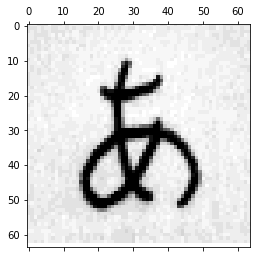

In [30]:
images = []
labels = []

for filename in [f'ETL7{batch}' for batch in ['LC_1','LC_2','SC_1','SC_2']]:

    n_recs = metadata[filename]  # retrieve the number of samples in this file

    with open(os.path.join(file_dir, filename), 'rb') as file:
        
        print(f'* Reading {filename}...')
        for i in tqdm(range(n_recs)):
            
            # the index (irrelevant)
            _ = file.read(2) 
            
            # the label
            label_bits = file.read(2)
            label = label_bits.decode('utf8').strip()
            labels.append(label)

            # metadata about this particular sample (irrelevant)
            _ = file.read(28)
            
            # the (64,63) image in 2016 bits (4 bits per pixel), value in range(0,16) (16=brightest)
            image_bits = file.read(2016)

            image = Image.frombytes('F', (64, 63), image_bits, 'bit', 4).point(lambda i: i / 16)

            image_array = np.asarray(image)
            image_array = np.pad(image_array,((0,1),(0,0)))  # pad the image to be (64,64), rather than (63,64)
            images.append(image_array)

            # unused bits at the end (irrelevant)
            _ = file.read(4)

images = np.asarray(images)
labels = np.asarray(labels)

print(f'There are {len(labels)} samples, where the LABELS are stored in an array of shape {labels.shape},')
print(f'and the IMAGES have been stored in a numpy array of shape {images.shape}.')
print(f'\nThis is the first sample: the hiragana "{labels[0]}".')
plt.matshow(images[0,:,:] * 255, cmap='Greys');

Alternatively, you can look up the first sample of other hiraganas here.

This is the first sample of MU.


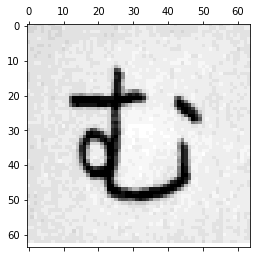

In [7]:
your_hiragana = 'MU'

try:
    i = labels.index(your_hiragana)
    image_array = images[i]
    print(f'This is the first sample of {your_hiragana}.')
    plt.matshow(image_array * 255, cmap='Greys');
except ValueError:
    print('''Please use a valid key: the hiragana should be romanized and capitalized;
    in addition, voiced hiraganas are not present in the sample.''')

### Encoding the textual labels into one-hot labels  
A function that returns a numpy array, where each row is a one-hot label.

In [31]:
def to_one_hot(labels, encoder, dimension=None):
    if dimension is None:
        dimension = len(set(labels))
    results = np.zeros((len(labels), dimension))
    for i, label in tqdm(enumerate(labels)):
        results[i, encoder[label]] = 1.
    return results

Provide a dictionary that maps texual labels to indices

In [32]:
goju_plus = goju + [',,', ',0']  # ",," is dakuten as in ば, while ",0" is handakuten as in ぱ

encoder = {item:index for index,item in enumerate(goju_plus)}

encoded_labels = to_one_hot(labels, encoder)

0it [00:00, ?it/s]

### Splitting the data into training and validation sets  
First shuffle the samples (the database has them in gojuon order by default):

KI


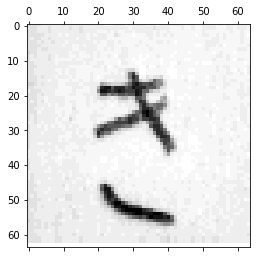

In [46]:
reordered = np.random.permutation(range(len(images)))

reordered_images = images[reordered]

reordered_labels = encoded_labels[reordered]

print(f"This is the first sample after shuffling: {goju_plus[list(reordered_labels[0]).index(1)]}")
plt.matshow(reordered_images[0] * 255, cmap='Greys')

Then assign a proportion of samples to the training set, and the rest to validation:

In [41]:
n_samples = len(labels)

train_proportion = 0.8
train_size = int(np.round(n_samples * train_proportion))

train_data = reordered_images[:train_size]
train_labels = reordered_labels[:train_size]

valid_data = reordered_images[train_size:]
valid_labels = reordered_labels[train_size:]

---
## Part II - Training the Model  
If the model is downloaded to the same folder, you can simply load it here:

In [3]:
# model = models.load_model('classifikanation')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-07 16:39:48.198583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-07 16:39:48.199161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Defining the network architecture  
The model converges quickly with minimal overfitting, and the ReduceLROnPlateau callback makes regularization unnecessary.

Plus, dropout makes training error higher than validation error (since it is only activated during training but not during validation), which makes error curves look weird.

In [55]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    #layers.Dropout(0.5)
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(48, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(learning_rate=1e-4),
            metrics=['acc'])

log_dir = 'logs'

callback_list = [
    callbacks.TensorBoard(
        log_dir = log_dir,
        histogram_freq = 1,
        embeddings_freq = 1),
    callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience = 10)]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 62, 62, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_21 (Bat  (None, 29, 29, 32)       128       
 chNormalization)                                                
                                                      

### Training the model

In [56]:
history = model.fit(
    train_data, train_labels,
    batch_size = 100,
    epochs = 20,
    validation_data = (valid_data,valid_labels),
    validation_batch_size= 100,
    callbacks = callback_list
)

save_dir = 'classifikanation'
model.save(save_dir)

Epoch 1/20


2022-10-03 16:45:45.620127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 3.1025 - acc: 0.2284

2022-10-03 16:46:07.033876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 24s 81ms/step - loss: 3.1025 - acc: 0.2284 - val_loss: 6.2081 - val_acc: 0.0220 - lr: 1.0000e-04
Epoch 2/20
269/269 [==============================] - 22s 80ms/step - loss: 1.5958 - acc: 0.6443 - val_loss: 2.8228 - val_acc: 0.2381 - lr: 1.0000e-04
Epoch 3/20
269/269 [==============================] - 22s 81ms/step - loss: 0.8794 - acc: 0.8353 - val_loss: 0.7355 - val_acc: 0.8595 - lr: 1.0000e-04
Epoch 4/20
269/269 [==============================] - 22s 81ms/step - loss: 0.5389 - acc: 0.9070 - val_loss: 0.4331 - val_acc: 0.9180 - lr: 1.0000e-04
Epoch 5/20
269/269 [==============================] - 22s 81ms/step - loss: 0.3642 - acc: 0.9382 - val_loss: 0.3162 - val_acc: 0.9417 - lr: 1.0000e-04
Epoch 6/20
269/269 [==============================] - 21s 79ms/step - loss: 0.2643 - acc: 0.9552 - val_loss: 0.2467 - val_acc: 0.9519 - lr: 1.0000e-04
Epoch 7/20
269/269 [==============================] - 21s 78ms/step - loss: 0.2013 - acc: 0.9668 - val_lo

INFO:tensorflow:Assets written to: classifikanation/assets


INFO:tensorflow:Assets written to: classifikanation/assets


### Inspecting the Model  
Via TensorBoard:

In [1]:
%load_ext tensorboard
%tensorboard --logdir=logs --host localhost --port 8088

# visit localhost:8088 to explore the model with tensorboard

Plotting the accuracies and losses:

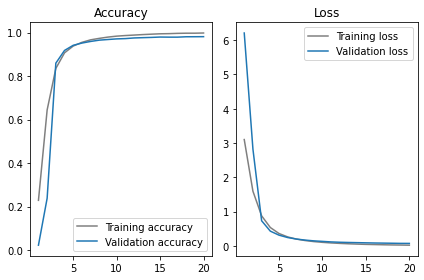

In [66]:
# the following function is adapted from Francois Chollet's book

def plot_performance(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'C7', label='Training accuracy')
    plt.plot(epochs, val_acc, 'C0', label='Validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'C7', label='Training loss')
    plt.plot(epochs, val_loss, 'C0', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_performance(history)

## Part III - Using the Model  
A function that loads an image and runs it through the model:

In [102]:
def differ(directory,model,size=(64,64),printing=True):
    img = Image.open(directory).resize(size).convert('L')
    plt.matshow(np.array(img) * 255, cmap='Greys');
    arr = np.array(img)[:,:]/255
    arr = arr.reshape((1,64,64,1))

    result = model.predict(arr)
    lesult = list(result[0,:])  # how likely the model considers the image to be each hiragana
    maxid = lesult.index(max(lesult))  # and index the hiragana that has the highest likelihood

    if printing:
        print('the model thinks ' + os.path.basename(directory)+' is '+ goju[maxid])
    return result

1/1 [==============================] - 0s 21ms/step
the model thinks hatest.jpg is HA


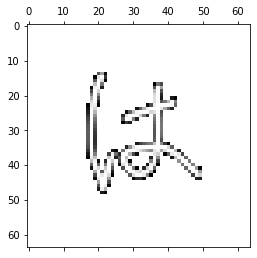

In [103]:
test_img = differ('hatest.jpg',model)

Inspect the activations of a particular layer:

2022-10-07 16:40:18.972603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-07 16:40:19.110668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


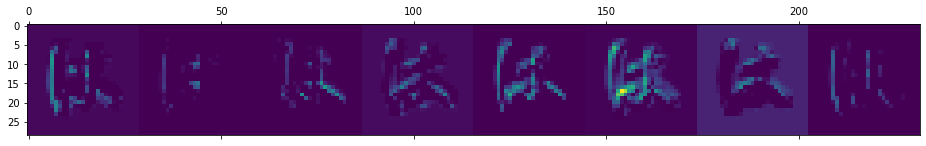

In [5]:
# this cell of code is adapted from Francois Chollet's book

max_depth = 12  # 12 layers before flattening

out = [layer.output for layer in model.layers[:max_depth]]
activation_model = models.Model(inputs=model.input, outputs=out)

def apply(directory,model,size=(64,64)):
    img = Image.open(directory).resize(size).convert('L')
    arr = np.array(img)[None,:,:]/255
    return model.predict(arr)

depth = 3  # which layer we are inspecting; 0,3,6,9 are Conv2D layers

layer_activations = apply('hatest.jpg',activation_model)[depth]

num_activations = layer_activations.shape[-1]
list_activations = [layer_activations[0,:,:,i] for i in range(0,num_activations,4)]
stacked_image = np.hstack(list_activations)
plt.matshow(stacked_image, cmap='viridis');

Inspecting the activation of multiple layers:

1/1 [==============================] - 0s 118ms/step


2022-10-07 16:40:22.456762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


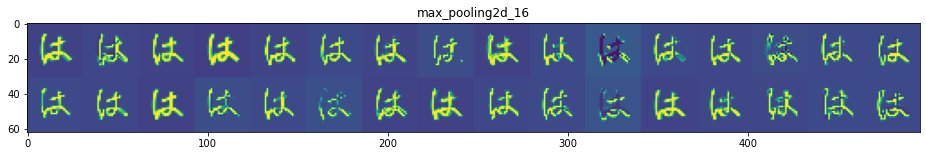

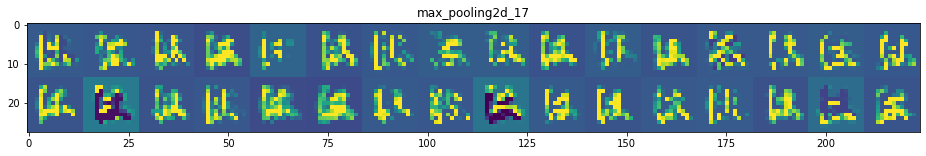

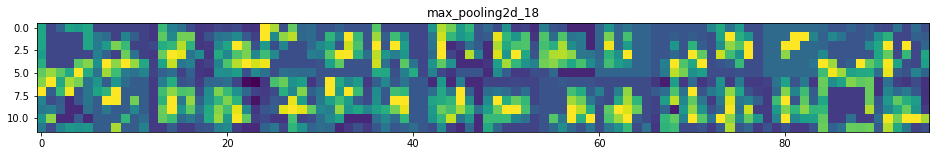

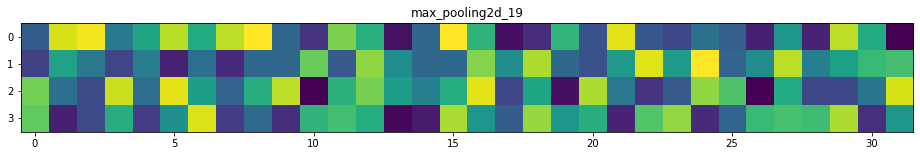

In [6]:
# the following functions are adapted from Francois Chollet's book

def arr_normalize(array):
    assert isinstance(array, np.ndarray)
    array -= array.mean()
    array /= array.std()
    return array

def visualize(image, model, depth=12, row_length=16, filter=['pooling']):
    layer_names = [layer.name for layer in model.layers[0:depth]]
    output = [layer.output for layer in model.layers[0:depth]]
    activation_model = models.Model(inputs=model.input, outputs=output)
    activations = apply(image,activation_model)
    
    for layer_name, layer_activation in zip(layer_names, activations):

        # if a list of filter keywords is provided, only visualize layers
        # that match (one of) the keywords
        if filter is None:
            pass
        elif not any(f in layer_name for f in filter):
            continue

        # building the grid for arranging the images
        _, size, _, n_features = layer_activation.shape

        ncols = n_features // row_length
        grid = np.zeros((size*ncols, size*row_length))

        # filling images into the grid
        for col in range(ncols):
            for row in range(row_length):
                current_channel = col*row_length + row
                channel_img = layer_activation[0,:,:,current_channel]
                channel_img = arr_normalize(channel_img)
                channel_img *= 64
                channel_img += 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')

                grid[col*size : (col+1)*size,
                    row*size : (row+1)*size] = channel_img
        
        # displaying the gridded images
        scale = 1/size
        plt.figure(figsize = (scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')

visualize('/Users/matthewan/Downloads/hatest.jpg', model, filter=['pooling'])